In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
IMAGE_RES = 299

In [3]:
(training_set,validation_set),dataset_info = tfds.load("tf_flowers",
                                                      with_info=True,
                                                      as_supervised=True,
                                                      split=['train[:70%]','train[70%:]'])

In [4]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1

In [5]:
num_training_examples

2569

In [6]:
num_validation_examples

1101

In [7]:
num_classes = dataset_info.features['label'].num_classes

In [8]:
num_classes

5

In [9]:
def format_image(image,label):
    image = tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
    return image, label

In [10]:
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(32).prefetch(1)
validation_batches = validation_set.map(format_image).batch(32).prefetch(1)

In [11]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

In [12]:
feature_extractor = hub.KerasLayer(URL,
                                  input_shape=(IMAGE_RES,IMAGE_RES,3),
                                  trainable=False)

In [13]:
model_inception = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes)
])

In [14]:
model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


Epoch 1/6
81/81 [==============================] - 886s 11s/step - loss: 0.8062 - accuracy: 0.6964 - val_loss: 0.4966 - val_accuracy: 0.8401
Epoch 2/6
81/81 [==============================] - 848s 11s/step - loss: 0.4216 - accuracy: 0.8622 - val_loss: 0.3849 - val_accuracy: 0.8783
Epoch 3/6
81/81 [==============================] - 854s 11s/step - loss: 0.3250 - accuracy: 0.8941 - val_loss: 0.3340 - val_accuracy: 0.8901
Epoch 4/6
81/81 [==============================] - 865s 11s/step - loss: 0.2789 - accuracy: 0.9136 - val_loss: 0.3244 - val_accuracy: 0.8856
Epoch 5/6
81/81 [==============================] - 860s 11s/step - loss: 0.2443 - accuracy: 0.9276 - val_loss: 0.3004 - val_accuracy: 0.8865
Epoch 6/6
81/81 [==============================] - 859s 11s/step - loss: 0.2151 - accuracy: 0.9330 - val_loss: 0.2887 - val_accuracy: 0.9010


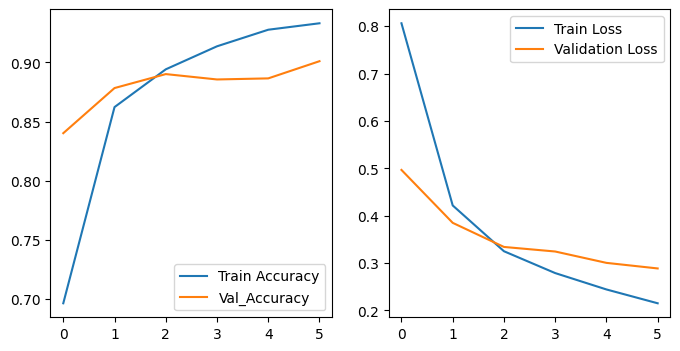

In [15]:
model_inception.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
Epochs = 6
history = model_inception.fit(train_batches,epochs=Epochs,
                             validation_data=validation_batches)
#plot Training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(Epochs)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Train Accuracy')
plt.plot(epochs_range,val_acc,label='Val_Accuracy')
plt.legend(loc=0)
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Train Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc=0)
plt.show()

In [18]:
class_names = np.array(dataset_info.features['label'].names)
image_batch,label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model_inception.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis=-1)

1/1 [==============================] - 9s 9s/step
